#Bike Sharing Demand prediction Project for the hourly dataset

### Step 0 - Import Libraries

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

### Step 1 - Read the data

In [3]:
bikes = pd.read_csv('/content/hour.csv')
bikes.head(3)

,index,date,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,demand
0,1,01-01-2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,01-01-2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,01-01-2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [4]:
bikes.shape

(17379, 17)

### Step 2 - Prelim Analysis and Feature Selection

In [6]:
bikes_prep = bikes.copy()
bikes_prep = bikes_prep.drop(
    ['index', 'date', 'casual', 'registered'], 
    axis = 1)

In [7]:
# Basic checks of missing values
bikes_prep.isnull().sum()

season        0
year          0
month         0
hour          0
holiday       0
weekday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
demand        0
dtype: int64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


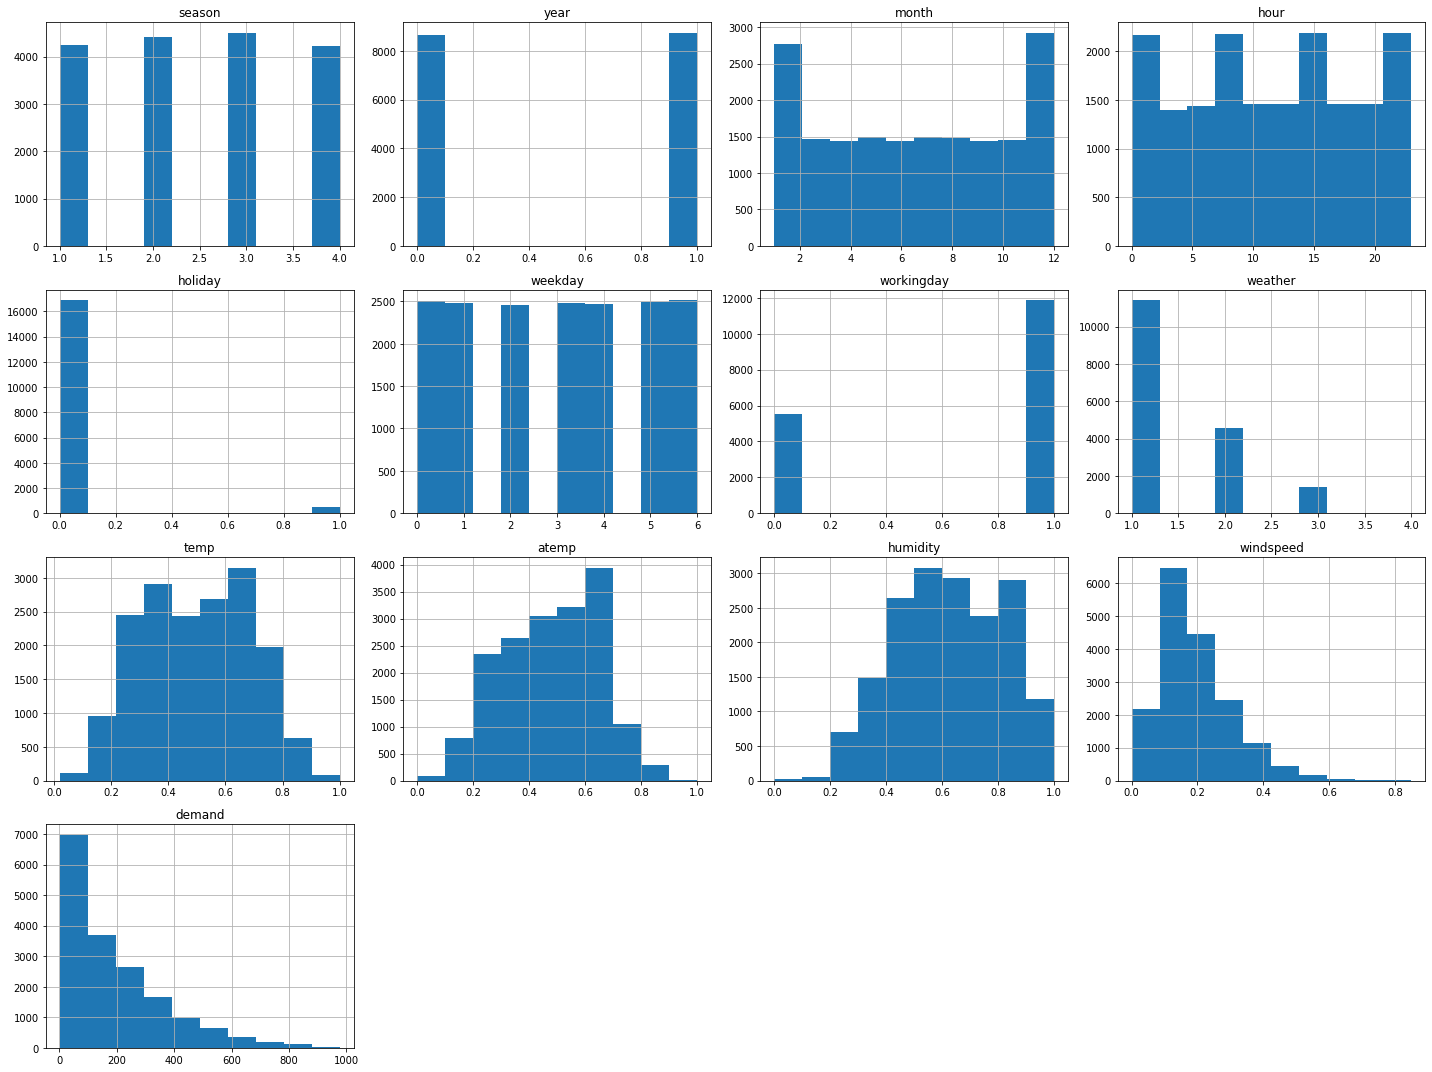

In [32]:
# Visualise the data using pandas histogram
fig = plt.figure(figsize = (20, 15))
ax = fig.gca()
bikes_prep.hist(ax = ax)
plt.tight_layout()
plt.show()

Target variable demand is not noramally distributed

### Step 3 - Data Visualisation

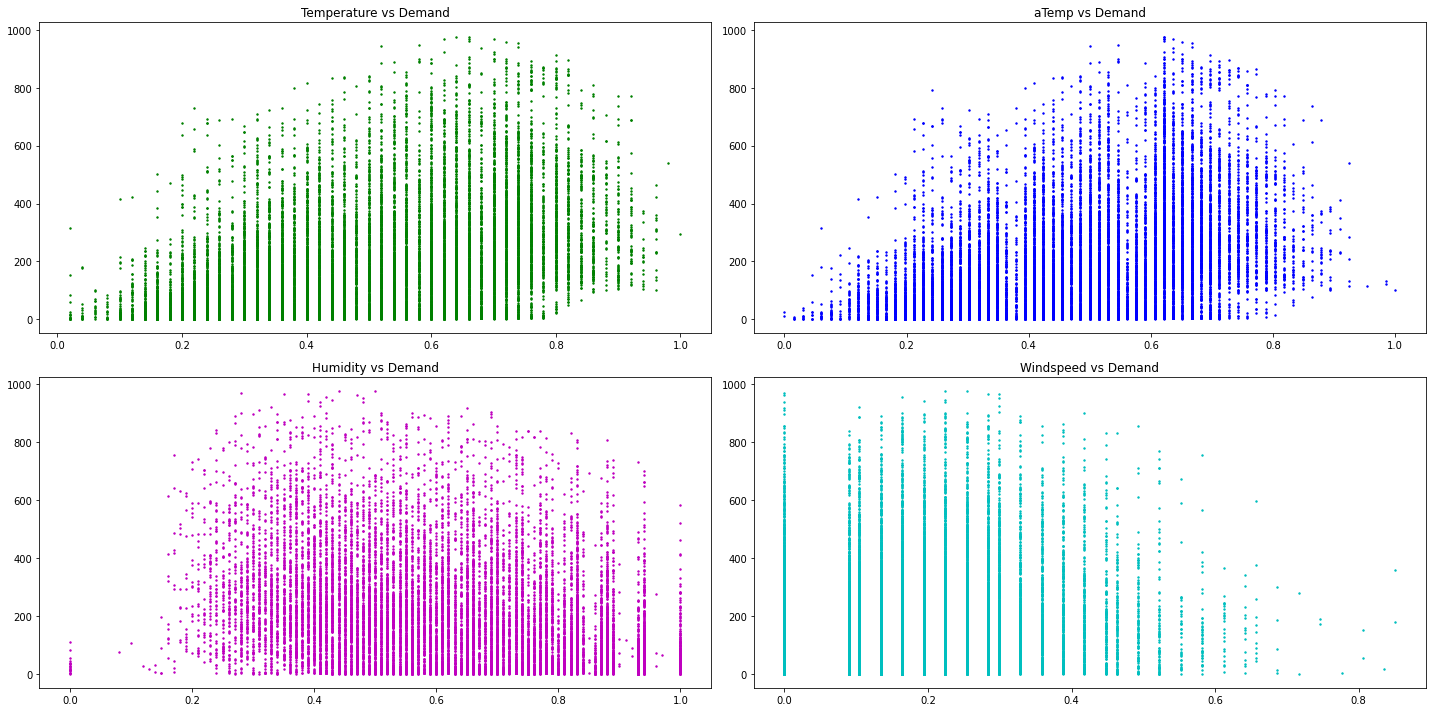

In [31]:
# Visualise the continuous features vs demand
plt.figure(figsize = (20, 10))
plt.subplot(2, 2, 1)
plt.scatter(x = bikes_prep['temp'], y = bikes_prep['demand'], s = 2, c = 'g')
plt.title('Temperature vs Demand')

plt.subplot(2, 2, 2)
plt.scatter(x = bikes_prep['atemp'], y = bikes_prep['demand'], s = 2, c = 'b')
plt.title('aTemp vs Demand')

plt.subplot(2, 2, 3)
plt.scatter(x = bikes_prep['humidity'], y = bikes_prep['demand'], s = 2, c = 'm')
plt.title('Humidity vs Demand')

plt.subplot(2, 2, 4)
plt.scatter(x = bikes_prep['windspeed'], y = bikes_prep['demand'], s = 2, c = 'c')
plt.title('Windspeed vs Demand')
plt.tight_layout()
plt.show()


Temperature and atemp have the same distribution


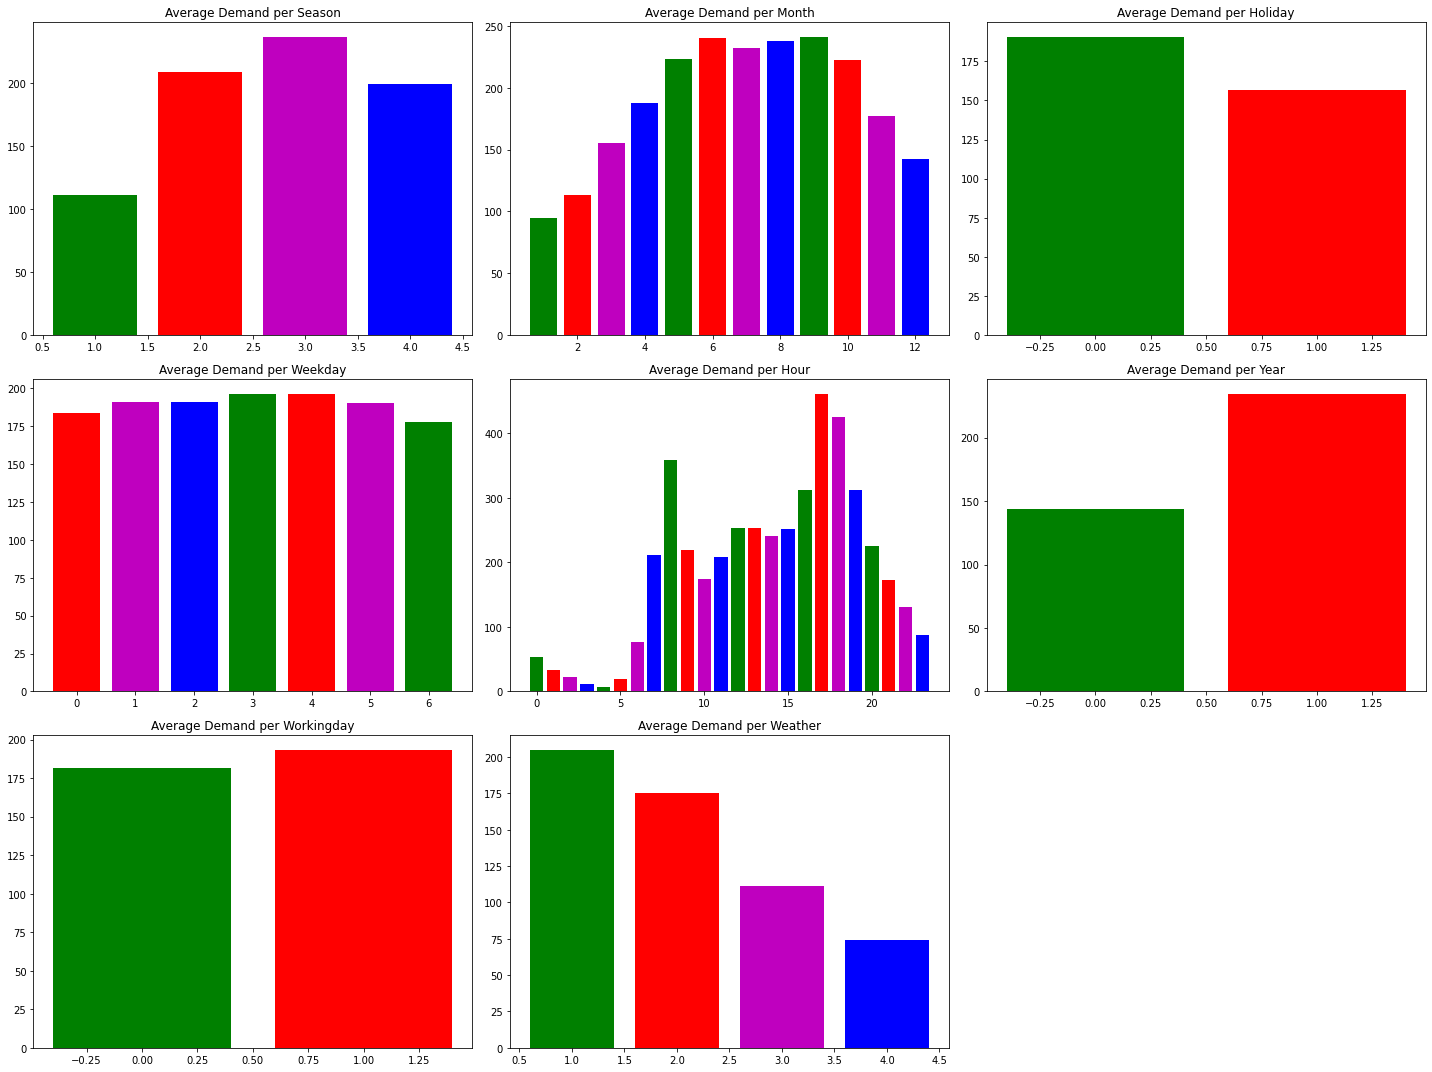

In [40]:
# Plot the categorical features vs demand
# Create a 3 x 3 subplot
colours = ['g', 'r', 'm', 'b']

plt.figure(figsize = (20, 15))
plt.subplot(3, 3, 1)
plt.title('Average Demand per Season')
cat_list = bikes_prep['season'].unique()
cat_average = bikes_prep.groupby('season').mean()['demand']
plt.bar(cat_list, cat_average, color = colours)

plt.subplot(3, 3, 2)
plt.title('Average Demand per Month')
cat_list = bikes_prep['month'].unique()
cat_average = bikes_prep.groupby('month').mean()['demand']
plt.bar(cat_list, cat_average, color = colours)

plt.subplot(3, 3, 3)
plt.title('Average Demand per Holiday')
cat_list = bikes_prep['holiday'].unique()
cat_average = bikes_prep.groupby('holiday').mean()['demand']
plt.bar(cat_list, cat_average, color = colours)

plt.subplot(3, 3, 4)
plt.title('Average Demand per Weekday')
cat_list = bikes_prep['weekday'].unique()
cat_average = bikes_prep.groupby('weekday').mean()['demand']
plt.bar(cat_list, cat_average, color = colours)

plt.subplot(3, 3, 5)
plt.title('Average Demand per Hour')
cat_list = bikes_prep['hour'].unique()
cat_average = bikes_prep.groupby('hour').mean()['demand']
plt.bar(cat_list, cat_average, color = colours)

plt.subplot(3, 3, 6)
plt.title('Average Demand per Year')
cat_list = bikes_prep['year'].unique()
cat_average = bikes_prep.groupby('year').mean()['demand']
plt.bar(cat_list, cat_average, color = colours)

plt.subplot(3, 3, 7)
plt.title('Average Demand per Workingday')
cat_list = bikes_prep['workingday'].unique()
cat_average = bikes_prep.groupby('workingday').mean()['demand']
plt.bar(cat_list, cat_average, color = colours)

plt.subplot(3, 3, 8)
plt.title('Average Demand per Weather')
cat_list = bikes_prep['weather'].unique()
cat_average = bikes_prep.groupby('weather').mean()['demand']
plt.bar(cat_list, cat_average, color = colours)

plt.tight_layout()
plt.show()

Features  to be dropped
1. weekday
2. year
3. workingday

In [41]:
# Check for outliers
bikes_prep['demand'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: demand, dtype: float64

In [42]:
bikes_prep['demand'].quantile([0.05, 0.1, 0.15, 0.9, 0.95, 0.99])

0.05      5.00
0.10      9.00
0.15     16.00
0.90    451.20
0.95    563.10
0.99    782.22
Name: demand, dtype: float64

We will drop the outliers

### Step 4 - Check Multiple Linear Regression Assumptions

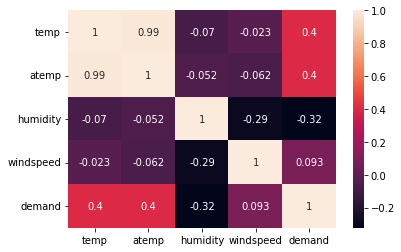

In [46]:
# Linearity using correlation coefficient matrix 
correlation = bikes_prep[['temp', 'atemp', 'humidity', 'windspeed', 'demand']].corr()
sns.heatmap(correlation, annot = True)
plt.show()


Features to be dropped
1. atemp
2. windspeed

In [47]:
bikes_prep = bikes_prep.drop(['atemp', 'windspeed', 'workingday', 'atemp', 'windspeed'], axis = 1)


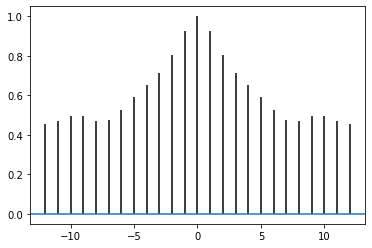

In [48]:
# Test Auto-Correlation in demand using acorr
df1 = pd.to_numeric(bikes_prep['demand'], downcast = 'float')

plt.acorr(df1, maxlags = 12)
plt.show()

There is high autocorrelation for the demand feature.

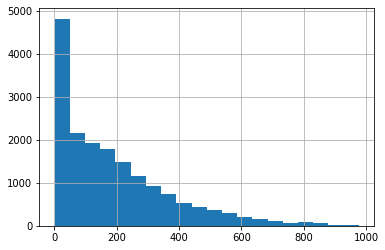

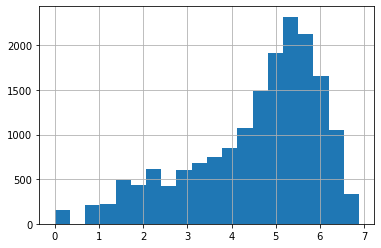

In [51]:
# Log Normalise the feature 'demand'
df1 = bikes_prep['demand']
df2 = np.log(df1)

plt.figure()
df1.hist(bins = 20)

plt.figure()
df2.hist(bins = 20)
plt.show()

In [52]:
bikes_prep['demand'] = np.log(bikes_prep['demand'])

In [54]:
# Solving the problem of Autocorrelation

t_1 = bikes_prep['demand'].shift(+1).to_frame()
t_1.columns = ['t-1']

t_2 = bikes_prep['demand'].shift(+2).to_frame()
t_2.columns = ['t-2']

t_3 = bikes_prep['demand'].shift(+3).to_frame()
t_3.columns = ['t-3']

bikes_prep_lag = pd.concat([bikes_prep, t_1, t_2, t_3], axis = 1)
bikes_prep_lag = bikes_prep_lag.dropna()


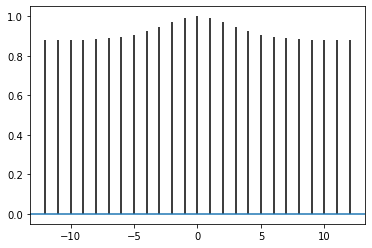

In [56]:
plt.acorr(bikes_prep_lag['demand'], maxlags = 12)
plt.show()

### Step 7 - Create Dummyvariablesand drop the first to avoid dummy variables trap 

In [58]:
bikes_prep_lag['season'] = bikes_prep_lag['season'].astype('category')
bikes_prep_lag['holiday'] = bikes_prep_lag['holiday'].astype('category')
bikes_prep_lag['weather'] = bikes_prep_lag['weather'].astype('category')
bikes_prep_lag['month'] = bikes_prep_lag['month'].astype('category')
bikes_prep_lag['hour'] = bikes_prep_lag['hour'].astype('category')

dummy_df = pd.get_dummies(bikes_prep_lag, drop_first = True)
dummy_df.head(3)

,year,weekday,temp,humidity,demand,t-1,t-2,t-3,season_2,season_3,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,holiday_1,weather_2,weather_3,weather_4
3,0,6,0.24,0.75,2.564949,3.465736,3.688879,2.772589,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,6,0.24,0.75,0.000000,2.564949,3.465736,3.688879,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,6,0.24,0.75,0.000000,0.000000,2.564949,3.465736,0,0,...,0,0,0,0,0,0,0,1,0,0


### Step 8 - Create Train and Test split

In [96]:
y = dummy_df[['demand']]
X = dummy_df.drop(['demand'], axis = 1)

In [97]:
# Create the size for 70% of the data
tr_size = 0.7 * len(X)
tr_size = int(tr_size)

In [98]:
X_train = X.values[0 : tr_size]
X_test = X.values[tr_size : len(X)]

In [99]:
y_train = y.values[0 : tr_size]
y_test = y.values[tr_size : len(y)]

### Step 9 - Fit and Score the model

In [100]:
from sklearn.linear_model import LinearRegression

std_reg = LinearRegression()
std_reg.fit(X_train, y_train)

r2_train = std_reg.score(X_train, y_train)
r2_test = std_reg.score(X_test, y_test)

y_predict = std_reg.predict(X_test)

from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(y_test, y_predict))

In [101]:
print(r2_train)

0.9232237454375068


In [102]:
print(r2_test)

0.9363979092039456


In [103]:
print(rmse)

0.3598722309463206


In [104]:
# Calculate RMSLE and compare results
y_test_e = []
y_predict_e = []

for i in range(len(y_test)):
  y_test_e.append(math.exp(y_test[i]))
  y_predict_e.append(math.exp(y_predict[i]))

log_sq_sum = 0.
# Do the sum of the logs and squares
for i in range(0, len(y_test_e)):
  log_a = math.log(y_test_e[i] + 1)
  log_p = math.log(y_predict_e[i] + 1)
  log_diff = (log_p - log_a)**2
  log_sq_sum = log_sq_sum + log_diff

rmsle = math.sqrt( log_sq_sum / len(y_test) )
print(rmsle)

0.3360706754410647
